# Data Analytics: Grammar Schools


## Settings

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
from dotenv import load_dotenv

load_dotenv()

True

In [57]:
from pathlib import Path

dirpath_data = Path("./data")
filepath_src = dirpath_data / "Grammar Schools in UK.xlsx"

dirpath_out = Path("./output")
filepath_out_mixed_order_by_dist = dirpath_out / "mixed-grammar-schools-order-by-dist-az.csv"

## Data Loading

In [58]:
import pandas as pd

df_src = pd.read_excel(filepath_src, sheet_name="Sheet1")
df_src

,School,Region,County
0,"Queen Elizabeth Grammar School, Penrith (mixed)",North West England,Cumbria
1,"Bacup and Rawtenstall Grammar School, Waterfoo...",North West England,Lancashire
2,"Clitheroe Royal Grammar School, Clitheroe (mixed)",North West England,Lancashire
3,"Lancaster Girls' Grammar School, Lancaster (gi...",North West England,Lancashire
4,"Lancaster Royal Grammar School, Lancaster (boys)",North West England,Lancashire
...,...,...,...
158,"Nonsuch High School for Girls, Cheam (girls)",Greater London,Sutton
159,"Sutton Grammar School for Boys, Sutton (boys)",Greater London,Sutton
160,"Wallington County Grammar School, Wallington (...",Greater London,Sutton
161,"Wallington High School for Girls, Wallington (...",Greater London,Sutton


## Data Cleanup

In [59]:
def transform_name_to_type(name: str) -> str:
    if "(girls)" in name:
        return "girls"
    elif "(boys)" in name:
        return "boys"
    else:
        return "mixed"
    
def transform_name_to_town(name: str) -> str:
    start, end = name.find(","), name.find("(") or len(name)
    return name[start+1:end].strip()

def cleanup_name(name: str) -> str:
    end = name.find(",")
    return name[:end].strip()

df_transform = df_src.copy()
df_transform["SchoolType"] = df_transform.School.map(transform_name_to_type)
df_transform["Town"] = df_transform.School.map(transform_name_to_town)
df_transform["School"] = df_transform["School"].map(cleanup_name)
df_transform = df_transform[["SchoolType", "School", "Region", "County", "Town"]]
df_transform

,SchoolType,School,Region,County,Town
0,mixed,Queen Elizabeth Grammar School,North West England,Cumbria,Penrith
1,mixed,Bacup and Rawtenstall Grammar School,North West England,Lancashire,Waterfoot
2,mixed,Clitheroe Royal Grammar School,North West England,Lancashire,Clitheroe
3,girls,Lancaster Girls' Grammar School,North West England,Lancashire,Lancaster
4,boys,Lancaster Royal Grammar School,North West England,Lancashire,Lancaster
...,...,...,...,...,...
158,girls,Nonsuch High School for Girls,Greater London,Sutton,Cheam
159,boys,Sutton Grammar School for Boys,Greater London,Sutton,Sutton
160,boys,Wallington County Grammar School,Greater London,Sutton,Wallington
161,girls,Wallington High School for Girls,Greater London,Sutton,Wallington


## Data Analysis

### Grammar Schools per Type

In [60]:
df_analysis_per_type = df_transform[["SchoolType", "School"]].groupby("SchoolType").count()

In [61]:
df_analysis_per_type

,School
SchoolType,
boys,58
girls,61
mixed,44


<Axes: ylabel='School'>

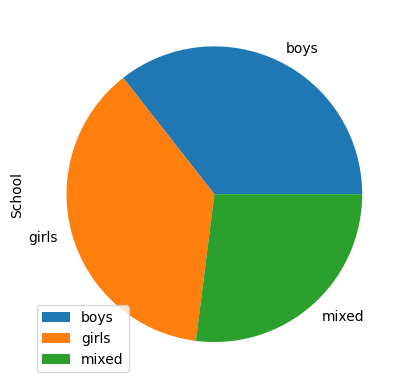

In [62]:
df_analysis_per_type.plot.pie(y="School")

### Mixed Grammar Schools per County

In [63]:
df_analysis_mixed_per_county = df_transform.copy()
df_analysis_mixed_per_county = df_analysis_mixed_per_county[df_analysis_mixed_per_county.SchoolType=="mixed"]
df_analysis_mixed_per_county = df_analysis_mixed_per_county[["County", "School"]].groupby("County").count()

In [64]:
df_analysis_mixed_per_county

,School
County,
Bexley,2
Birmingham,1
Buckinghamshire,5
Calderdale,2
Cumbria,1
Devon,1
Enfield,1
Gloucestershire,2
Kent,6


<Axes: ylabel='County'>

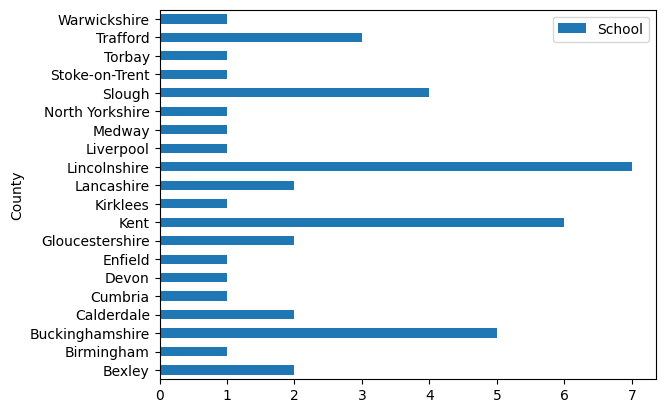

In [65]:
df_analysis_mixed_per_county.plot.barh()

### Top 3 Counties with More Grammar Schools

In [66]:
top_3_counties = df_analysis_mixed_per_county.sort_values(by="School", ascending=False)[0:3].index.values
top_3_counties.tolist()

['Lincolnshire', 'Kent', 'Buckinghamshire']

### Grammar Schools by Distance to Canary Wharf

In [67]:
import os
import re
import requests
import pandas as pd

def tranform_row_to_address(row: pd.Series) -> str:
    if not hasattr(row, "Address") or row.Address is None:
        url = "https://maps.googleapis.com/maps/api/geocode/json"
        address = f"{row.School}, {row.Town}, {row.County}"
        params = dict(key=os.environ["GCP_API_KEY"], address=address)
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                formatted_address = data['results'][0]['formatted_address']
                return formatted_address
    else:
        return row.Address

def tranform_addess_to_route_to_canary_wharf(row: pd.Series) -> str:
    if not hasattr(row, "Route") or row.Route is None:
        url = "https://maps.googleapis.com/maps/api/directions/json"
        params = dict(key=os.environ["GCP_API_KEY"], origin=row.Address, destination="Canary Wharf Station, London", mode="transit")
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                distance = data['routes'][0]['legs'][0]['distance']['text']
                duration = data['routes'][0]['legs'][0]['duration']['text']
                return str((distance, duration))
    else:
        return row.Route
    
def tansform_route_to_duration_in_km(row: pd.Series) -> int:
    if not hasattr(row, "RouteInKm") or row.RouteInKm is None:
        return row.Route[1:-1].split(",")[0].strip()[1:-1]
    else:
        return row.RouteInKm

def tansform_route_to_duration_in_mins(row: pd.Series) -> int:
    if not hasattr(row, "RouteInMins") or row.RouteInMins is None:
        time_str = row.Route[1:-1].split(",")[1].strip()[1:-1]
        pattern = r'(?:(\d+)\s*hours?)?\s*(?:(\d+)\s*mins?)?'
        match = re.match(pattern, time_str)
        total_minutes = 0
        if match:
            hours = match.group(1)
            minutes = match.group(2)
            total_minutes += int(hours) * 60 if hours else 0
            total_minutes += int(minutes) if minutes else 0           
        return total_minutes
    else:
        return row.RouteInMins
    
df_analysis_mixed_with_dist = None
if not filepath_out_mixed_order_by_dist.exists():
    df_analysis_mixed_with_dist = df_transform.copy()
    df_analysis_mixed_with_dist = df_analysis_mixed_with_dist[df_analysis_mixed_with_dist.SchoolType == "mixed"]
    df_analysis_mixed_with_dist = df_analysis_mixed_with_dist[["County", "Town", "School"]]
else:
    df_analysis_mixed_with_dist = pd.read_csv(filepath_out_mixed_order_by_dist)
    
df_analysis_mixed_with_dist["Address"] = df_analysis_mixed_with_dist.apply(tranform_row_to_address, axis=1)
df_analysis_mixed_with_dist["Route"] = df_analysis_mixed_with_dist.apply(tranform_addess_to_route_to_canary_wharf, axis=1)
df_analysis_mixed_with_dist["RouteInKm"] = df_analysis_mixed_with_dist.apply(tansform_route_to_duration_in_km, axis=1)
df_analysis_mixed_with_dist["RouteInMins"] = df_analysis_mixed_with_dist.apply(tansform_route_to_duration_in_mins, axis=1)
df_analysis_mixed_with_dist.sort_values(by=["RouteInMins", "County", "Town", "School"], inplace=True)
df_analysis_mixed_with_dist.reset_index(inplace=True, drop=True)
df_analysis_mixed_with_dist.to_csv(filepath_out_mixed_order_by_dist, index=False)
df_analysis_mixed_with_dist[[c for c in df_analysis_mixed_with_dist.columns.tolist() if c != "Route"]]

,County,Town,School,Address,RouteInKm,RouteInMins
0,Bexley,Welling,Bexley Grammar School,"Danson Ln, Welling DA16 2BL, UK",14.3 km,47
1,Bexley,Sidcup,Chislehurst and Sidcup Grammar School,"Hurst Rd, Sidcup DA15 9AG, UK",16.4 km,58
2,Enfield,Edmonton,The Latymer School,"Latymer Secondary School, Haselbury Rd, London...",21.0 km,77
3,Slough,Slough,Upton Court Grammar School,"Lascelles Rd, London, Slough SL3 7PR, UK",45.0 km,82
4,Slough,Langley,Langley Grammar School,"Langley Grammar School, Reddington Dr, Langley...",41.2 km,84
5,Slough,Langley,St Bernard's Catholic Grammar School,"St. Bernards Catholic Grammar School, 1 Langle...",45.4 km,84
6,Slough,Slough,Herschel Grammar School,"Berkshire, Northampton Ave, Slough SL1 3BW, UK",44.7 km,102
7,Buckinghamshire,Aylesbury,Sir Henry Floyd Grammar School,"Oxford Rd, Aylesbury HP21 8PE, UK",75.4 km,106
8,Kent,Cranbrook,Cranbrook School,"Waterloo Rd, Cranbrook TN17 3JD, UK",80.4 km,107
9,Kent,Canterbury,Barton Court Grammar School,"Longport, Canterbury CT1 1PH, UK",91.6 km,128
